<div style="display: flex; align-items: center;">
    <img src="https://github.com/nagelt/Teaching_Scripts/raw/9d9e29ecca4b04eaf7397938eacbf116d37ddc93/Images/TUBAF_Logo_blau.png" width="500" height="auto" height="auto" style="margin-right: 100px;" />
    <div>
        <p><strong>Prof. Dr. Thomas Nagel</strong></p>
        <p>Chair of Soil Mechanics and Foundation Engineering<br>Geotechnical Institute<br>Technische Universität Bergakademie Freiberg.</p>
        <p><a href="https://tu-freiberg.de/en/soilmechanics">https://tu-freiberg.de/en/soilmechanics</a></p>
    </div>
</div>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
sp.init_printing()
#Some plot settings
import plot_functions.plot_settings

# Vertical steady-state profiles of hydraulic head / pore water pressure

We will study the impact of inhomogeneous hydraulic conductivity fields using the hydraulic steady-state combination of Darcy's law and the continuity equation:

$$
    0 = \partial_z (k_\text{f} \partial_z h)
$$

We further note that

$$
    \text{d}h = \frac{\text{d}u}{\gamma_\text{w}} + \text{d}z
$$

In [2]:
gamma_w = 10. #kN/m³

## Homeogeneous aquidard

Consider a homogeneous low-permeable layer confined by two aquifers of differing hydraulic heads.

In [17]:
z, h_top, h_bot, H = sp.symbols('z h_top h_bot H', real=True, positive=True)

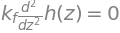

In [20]:

kf = sp.symbols('k_f', real=True, positive=True)
h = sp.Function('h')(z)
DGL = sp.Eq(sp.diff(kf * sp.diff(h, z), z), 0)
DGL

In [24]:
# Integrate DGL twice
h_solution = sp.dsolve(DGL, h)

# Apply boundary conditions
C1, C2 = sp.symbols('C1 C2')
constants = sp.solve([h_solution.rhs.subs(z, 0) - h_bot, h_solution.rhs.subs(z, H) - h_top], (C1, C2))

# General solution with constants
h_solution = h_solution.subs(constants)
h_solution

The result for a constant $k_\text{f}$ value is the expected linear distribution between the two boundary potentials:

$$
    h(z) = h_\text{bot} + (h_\text{top} - h_\text{bot}) \frac{z}{H}
$$

## Inhomogeneous aquidard

Now we look at a layer whose hydraulic conductivity decreases with depth.

$$
    k_\text{f}(z) = k_\text{bot} \left( \frac{k_\text{top}}{k_\text{bot}} \right)^{\frac{z}{H}}
$$

In [25]:
k_to_kbot = lambda zeta, k_top_to_k_bot: k_top_to_k_bot**zeta

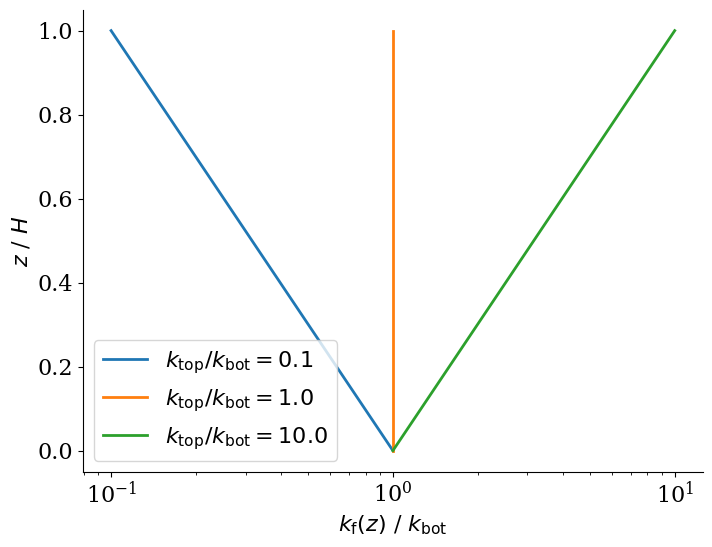

In [47]:
zeta_vals = np.linspace(0, 1, 3)
fig, ax = plt.subplots()

for i in [0.1, 1, 10]:
    ax.plot(k_to_kbot(zeta_vals, i), zeta_vals, label=r'$k_\mathrm{top}/k_\mathrm{bot} = %.1f$' % i)

ax.legend()
ax.set_ylabel(r'$z$ / $H$')
ax.set_xlabel(r'$k_\text{f}(z)$ / $k_\mathrm{bot}$')
ax.set_xscale('log')

In [35]:
k_top, k_bot = sp.symbols('k_top k_bot', real=True, positive=True)
kf = k_bot * sp.Pow(k_top/k_bot, z/H)
kf


In [37]:
h = sp.Function('h')(z)
DGL = sp.Eq(sp.diff(kf * sp.diff(h, z), z), 0)

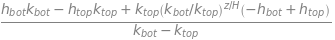

In [43]:
# Integrate DGL twice
h_solution = sp.dsolve(DGL, h)

# Apply boundary conditions
C1, C2 = sp.symbols('C1 C2')
constants = sp.solve([h_solution.rhs.subs(z, 0) - h_bot, h_solution.rhs.subs(z, H) - h_top], (C1, C2))

# General solution with constants
h_solution = h_solution.subs(constants)
h_anom = h_solution.simplify()
h_anom

Die resultierende Verteilung der hydraulischen Höhe ist nichtlinear:

$$
    h(z) = \frac{h_\text{bot} k_\text{bot} - h_\text{top} k_\text{top}}{k_\text{bot} - k_\text{top}} + \frac{h_\text{top} - h_\text{bot}}{k_\text{bot} - k_\text{top}} k_\text{top} \left( \frac{k_\text{bot}}{k_\text{top}} \right)^{\frac{z}{H}}
$$

In [45]:
def h_anom_np(zeta, h_bot, h_top, k_bot, k_top):
    term1 = (h_bot * k_bot - h_top * k_top) / (k_bot - k_top)
    term2 = (h_top - h_bot) / (k_bot - k_top) * k_top * (k_bot / k_top) ** (zeta)
    return term1 + term2

In [46]:
def h_solution_np(zeta, h_bot, h_top):
    return h_bot + (h_top - h_bot) * (zeta)

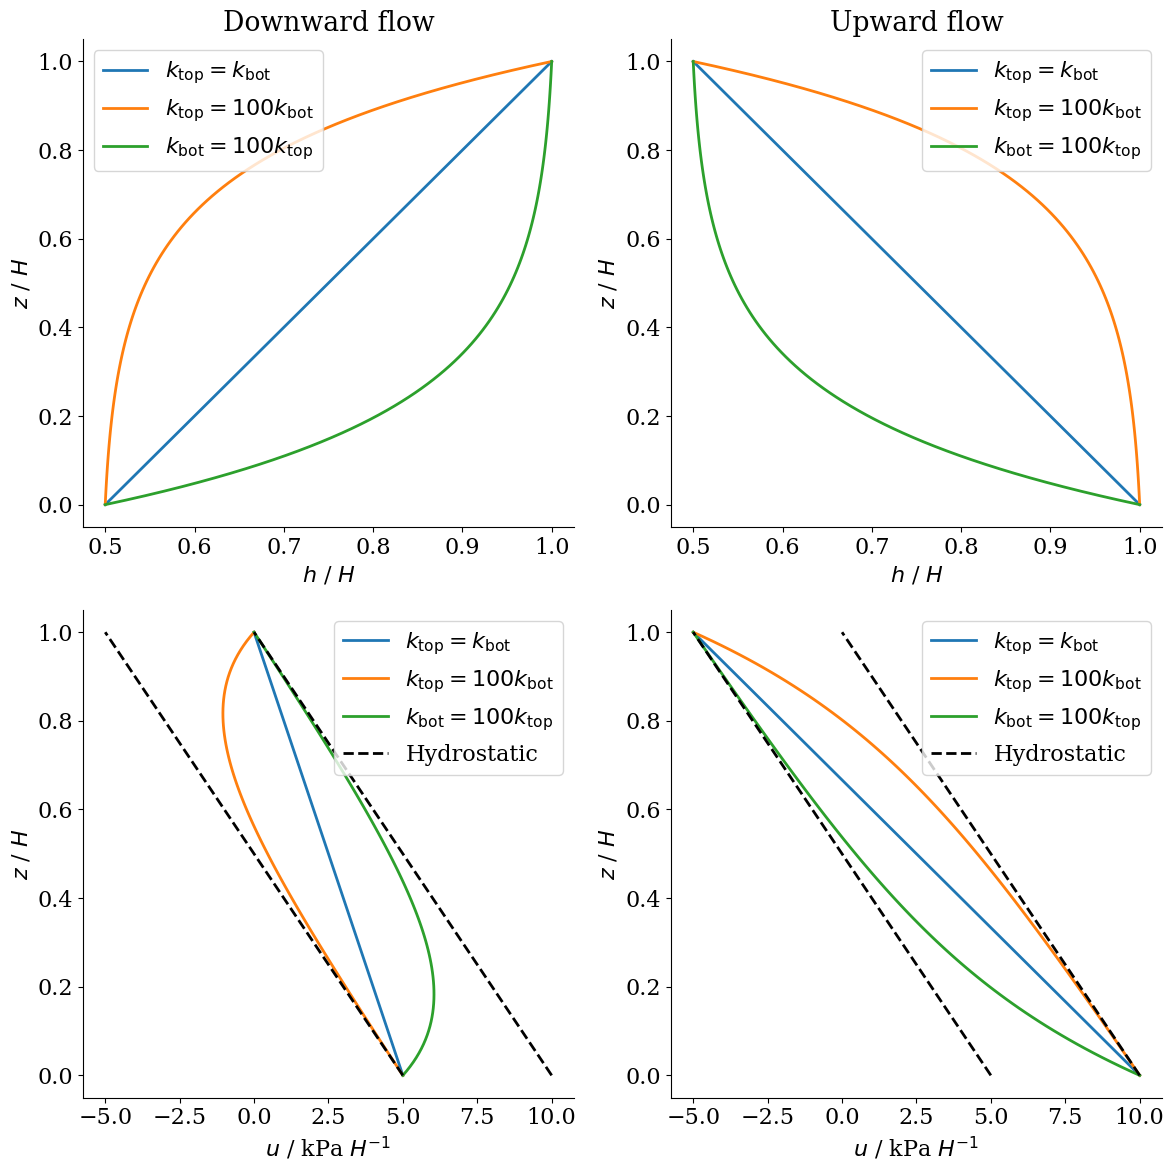

In [84]:
zeta_vals = np.linspace(0, 1, 100)
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

# Top row: h_solution_np and h_anom_np
ax[0, 0].set_title('Downward flow')
ax[0, 0].plot(h_solution_np(zeta_vals, 0.5, 1), zeta_vals, label=r'$k_\mathrm{top} = k_\mathrm{bot}$')
ax[0, 0].plot(h_anom_np(zeta_vals, 0.5, 1, 1e-1, 1e-3), zeta_vals, label=r'$k_\mathrm{top} = 100 k_\mathrm{bot}$')
ax[0, 0].plot(h_anom_np(zeta_vals, 0.5, 1, 1e-3, 1e-1), zeta_vals, label=r'$k_\mathrm{bot} = 100 k_\mathrm{top}$')

ax[0, 1].set_title('Upward flow')
ax[0, 1].plot(h_solution_np(zeta_vals, 1, 0.5), zeta_vals, label=r'$k_\mathrm{top} = k_\mathrm{bot}$')
ax[0, 1].plot(h_anom_np(zeta_vals, 1, 0.5, 1e-1, 1e-3), zeta_vals, label=r'$k_\mathrm{top} = 100 k_\mathrm{bot}$')
ax[0, 1].plot(h_anom_np(zeta_vals, 1, 0.5, 1e-3, 1e-1), zeta_vals, label=r'$k_\mathrm{bot} = 100 k_\mathrm{top}$')

u_from_head = lambda h, z: (h-z)*gamma_w

# Bottom row: u_from_head
ax[1, 0].plot(u_from_head(h_solution_np(zeta_vals, 0.5, 1), zeta_vals), zeta_vals, label=r'$k_\mathrm{top} = k_\mathrm{bot}$')
ax[1, 0].plot(u_from_head(h_anom_np(zeta_vals, 0.5, 1, 1e-1, 1e-3), zeta_vals), zeta_vals, label=r'$k_\mathrm{top} = 100 k_\mathrm{bot}$')
ax[1, 0].plot(u_from_head(h_anom_np(zeta_vals, 0.5, 1, 1e-3, 1e-1), zeta_vals), zeta_vals, label=r'$k_\mathrm{bot} = 100 k_\mathrm{top}$')
ax[1, 0].plot(-gamma_w*zeta_vals+1*gamma_w,zeta_vals,color='black',linestyle='--',label='Hydrostatic')
ax[1, 0].plot(-gamma_w*zeta_vals+0.5*gamma_w,zeta_vals,color='black',linestyle='--')


ax[1, 1].plot(u_from_head(h_solution_np(zeta_vals, 1, 0.5), zeta_vals), zeta_vals, label=r'$k_\mathrm{top} = k_\mathrm{bot}$')
ax[1, 1].plot(u_from_head(h_anom_np(zeta_vals, 1, 0.5, 1e-1, 1e-3), zeta_vals), zeta_vals, label=r'$k_\mathrm{top} = 100 k_\mathrm{bot}$')
ax[1, 1].plot(u_from_head(h_anom_np(zeta_vals, 1, 0.5, 1e-3, 1e-1), zeta_vals), zeta_vals, label=r'$k_\mathrm{bot} = 100 k_\mathrm{top}$')
ax[1, 1].plot(-gamma_w*zeta_vals+0.5*gamma_w,zeta_vals,color='black',linestyle='--',label='Hydrostatic')
ax[1, 1].plot(-gamma_w*zeta_vals+gamma_w,zeta_vals,color='black',linestyle='--')


for i in range(2):
    for j in range(2):
        ax[i, j].legend()
        ax[i, j].set_ylabel(r'$z$ / $H$')
        ax[i, j].set_xlabel(r'$h$ / $H$' if i == 0 else r'$u$ / kPa $H^{-1}$')

fig.tight_layout()

One can observe how non-linear pore water pressure / head distributions result from inhomogeneous conductivity fields.

Conversely, one can re-construct hypothetical $k_\text{f}$ fields from head measurements and compare them to test data.